In [1]:
import sys
if '/' in sys.path[0]:
    sys.path.append(r'/home/elisa/PycharmProjects/gempy')
elif '\\' in sys.path[0]:
    sys.path.append(r'C:/users/elisa/documents/git/gempy')

import gempy as gp

import numpy as np
import matplotlib.pyplot as plt

C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implemen

### Regular model setup

Active grids: ['regular']
[ 800. 1000.]
Active grids: ['regular' 'topography']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                   values
range            1732.05
$C_o$            71428.6
drift equations   [3, 3]


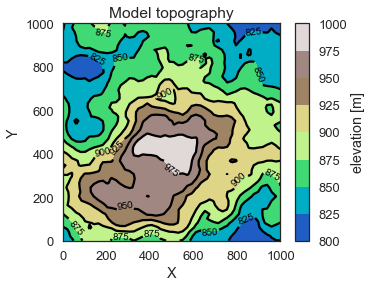

In [4]:
resolution = [50,50,50]
    
geo_model = gp.create_model('faultmodel')

gp.init_data(geo_model, extent=[0,1000,0,1000,0,1000],resolution = resolution,
                         path_i = r"data/faultuncertainty_interfaces_surface.csv",
                         path_o = r"data/faultuncertainty_orient_surface.csv")

gp.map_series_to_surfaces(geo_model, {'fault_series':'fault','form_series':('layer2','layer1','basement')})
geo_model.surfaces.colors.change_colors({'layer1': '#ffbe00', 'layer2': '#9f0052', 'fault': '#015482',
                                        'basement': '#728f02'})

geo_model.set_is_fault(['fault_series'],change_color=False)

geo_model.set_topography(source='random')

gp.set_interpolation_data(geo_model,
                          compile_theano=True,
                          theano_optimizer='fast_compile',
                          verbose=[])
sol = gp.compute_model(geo_model, compute_mesh=False)

### Export the model as vtr object (not necessarily necessary)

In [6]:
mblock = geo_model.solutions.lith_block.reshape(geo_model.grid.regular_grid.resolution).copy()
mblock[geo_model.grid.regular_grid.mask_topo] =-1 # indicate values above topography

file = 'faultmodel'
gp.plot.export_to_vtk(geo_model, file, block=mblock, surfaces=False)

True

### Load the file and create a static 3D image

In [7]:
import pyvista as pv
import matplotlib.colors as mcolors
pv.set_plot_theme('document') # white background

In [11]:
cmap = mcolors.ListedColormap(list(geo_model.surfaces.df['color'])[1:])

In [19]:
filename = file+'_lith_block.vtr'
grid = pv.read(filename)
masktopo = grid.threshold(0) # to remove values lower than 0 (ie topography)
surf = masktopo.extract_geometry() # get only outer layers of lithology block

p = pv.Plotter() #create plot object
p.add_mesh(surf, cmap=cmap, show_scalar_bar=False) # add the lithology block
#p.show()

(vtkRenderingOpenGL2Python.vtkOpenGLActor)00000171E3EE3D08

In [20]:
print(p.camera_position)

[(500.0, 500.0, 3846.0652149512316), (500.0, 500.0, 500.0), (0.0, 1.0, 0.0)]


### Let it rotate and save in gif
1. print p.camera_position (cell above) and copy these values in the first line of the next cell (this is to get the optimal camera position, but you can also define your own)
2. Run the cell above where the 3D block is created again, but delete the last line (p.show) so that you don't see the 3D model as output anymore (somehow this is necessary to reset the plotter object)
3. In the following cell, define gifname
4. Define nmframe - the number of frames (for each frame an image is created - the higher, the more beautiful and heavier the resulting video)
5. Run the cell and hope that it creates a nice gif. If it creates a static image, run the cell above where the plotter object is created again before running the next cell, but without the p.show() command
6. For further processing of gifs, like defining the time of every frame or the number of loops, https://ezgif.com/ is a nice resource

In [21]:
gifname = 'rotateme.gif'
nframe = 100


p.camera_position= [(2431.851652578137, 2431.851652578137, 2431.851652578137), (500.0, 500.0, 500.0), (0.0, 0.0, 1.0)]
p.open_gif(gifname)
x = p.camera_position[0][0]
y = p.camera_position[0][1] 
z = p.camera_position[0][2]
focal_point = p.camera_position[1]
viewup = p.camera_position[2]

radius = np.sqrt((x-focal_point[0])**2 + (y-focal_point[1])**2)

dPsi = (2*np.pi) / (nframe-1)
psi = np.arccos((x-focal_point[0])/radius)*-1 # define starting angle based on current camera position

for i in range(nframe): # for every frame, rotate the camera by an angle of dPsi
    xx = radius * np.cos(psi) + focal_point[0]
    yy = radius * np.sin(psi) + focal_point[1]
    psi += dPsi
    p.camera_position = [
        (xx, yy, z),
        focal_point,
        viewup,      
    ]
    p.write_frame()
# Close movie and delete object
p.close()